__TP on Adversarial Bandits - Julien GUEGAN__

In [1]:
import numpy as np
from numpy.random import rand
import math
import matplotlib
import matplotlib.pyplot as plt
from numpy.linalg import norm

In [2]:
matplotlib.rcParams['font.size'] = 15

## Question 1

In [3]:
L = np.array([[ 0., -1.,  1.], [ 1.,  0., -1.], [-1.,  1.,  0.]])
L

array([[ 0., -1.,  1.],
       [ 1.,  0., -1.],
       [-1.,  1.,  0.]])

# Full information feedback

## Question 2

In [4]:
def rand_exp(p):
    
    return np.random.choice(np.arange(0, len(p)), p = p)


$$ \underline{\text{EWA update}} :  p_{t+1}(k) = \frac{e^{-\eta \sum_{s=1}^t l_s(k)}}{\sum_{j=1}^K e^{- \eta \sum_{s=1}^t l_s(j)}} $$

In [5]:
def EWA_update(p, l, eta):
    
    return p * np.exp(-eta * l) / np.sum(p * np.exp(-eta * l))


In [6]:
p_t = [1/3, 1/3, 1/3]
eta = 1
l_t = L[:,0] 
              
EWA_update(p_t, l_t, 1)

array([0.24472847, 0.09003057, 0.66524096])

In [7]:
def simulate_EWA(T, eta, L, q, adversary):
    
    # initialization
    loss = np.zeros(T)
    p    = np.zeros((T+1,3))
    p[0,:] = np.ones(len(L))/len(L)
    q0  = np.ones(len(L))/len(L)
    q   = np.tile(q0,(T+1,1))
    
    # loop over time
    for t in range(T):
        action_player = rand_exp(p[t,:])
        action_advers = rand_exp(q[t,:])
        loss[t]       = L[action_player, action_advers]
        p[t+1,:]      = EWA_update(p[t,:], L[:,action_advers], eta)
        if (adversary == "adaptative"):
            q[t+1,:] = EWA_update(q[t,:], L[:,action_player], eta)

    # compute quantities
    average_loss = np.cumsum(loss)/(np.arange(T)+1)
    regret       = np.cumsum(loss - (-1))

    return loss, p, average_loss, regret

## Question 3 : fixed adversary

In [8]:
q   = [1/2, 1/4, 1/4]
T   = 100
eta = 1
_, p, average_loss, regret = simulate_EWA(T, eta, L, q, 'fixed')

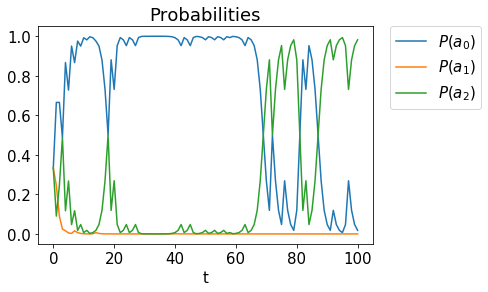

In [9]:
plt.plot(p)
plt.legend(('$P(a_0)$', '$P(a_1)$', '$P(a_2)$'),bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.title('Probabilities')
plt.xlabel('t')
plt.show()

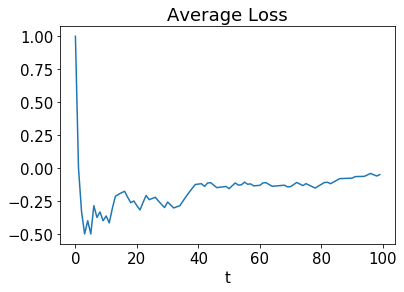

In [10]:
plt.plot(average_loss)
plt.title('Average Loss')
plt.xlabel('t')
plt.show()

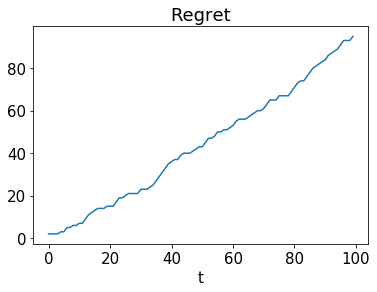

In [11]:
plt.plot(regret)
plt.title('Regret')
plt.xlabel('t')
plt.show()

In [12]:
N    = 10
average_losses = []
for n in range(N):
    _, _, average_loss_n, _ = simulate_EWA(T, eta, L, q, 'fixed')
    average_losses.append(average_loss_n)

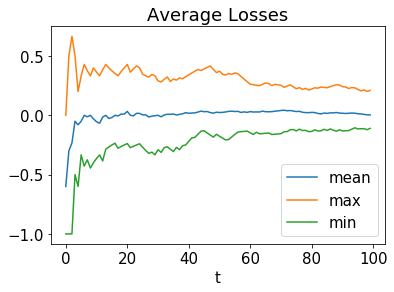

In [13]:
plt.plot(np.mean(average_losses,axis=0),label='mean')
plt.plot(np.max(average_losses,axis=0),label='max')
plt.plot(np.min(average_losses,axis=0),label='min')
plt.title('Average Losses')
plt.xlabel('t')
plt.legend()
plt.show()

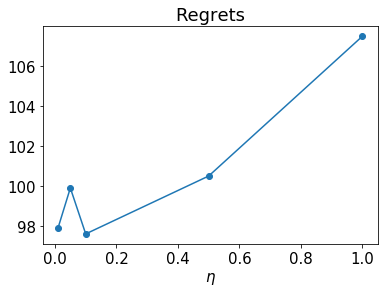

In [14]:
regrets = []
etas    = [0.01, 0.05, 0.1, 0.5, 1]
for eta in etas:
    regret_i = []
    for n in range(N):
        _, _, _, regret = simulate_EWA(T, eta, L, q, 'fixed')
        regret_i.append(regret[-1])
    regrets.append(np.mean(regret_i))
    
plt.plot(etas, regrets, 'o-')
plt.title('Regrets')
plt.xlabel('$\eta$')
plt.show()

__It seems that in practice, the best $\eta$ is around 0.1, while in theory it is optimal for $\eta = \sqrt{\frac{\log K}{K T}} $ (~0.06).__

## Question 4 : adaptative adversary

In [15]:
T   = 100
eta = 1
_, p, average_loss, _ = simulate_EWA(T, eta, L, '', 'adaptative')

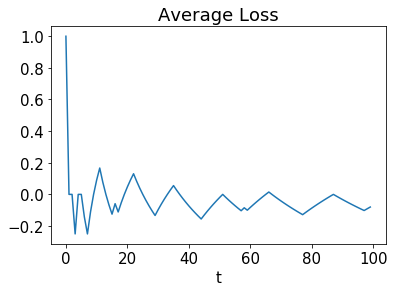

In [16]:
plt.plot(average_loss)
plt.title('Average Loss')
plt.xlabel('t')
plt.show()

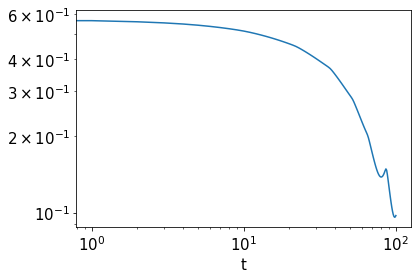

In [17]:
average_p = np.cumsum(p,axis=0)/T
plt.loglog(norm(average_p - [1/3, 1/3, 1/3], axis=1))
plt.xlabel('t')
plt.show()

# Bandit Feedback

## Question 5

$$ \underline{\text{EXP3 update}} : p_{t+1}(k) = \frac{e^{-\eta \sum_{s=1}^t \hat{l_s}(k)}}{\sum_{j=1}^K e^{- \eta \sum_{s=1}^t \hat{l_s}(j)}} \ \text{where} \  \hat{l_s}(k) = \frac{l_s(k)}{p_s(k)}\mathbb{1}_{k=x_s} $$

In [18]:
def estimated_loss(i, L_ij):
    
    estimated_loss    = np.zeros(3)
    estimated_loss[i] = L_ij
    
    return estimated_loss


In [19]:
def EXP3_update(p, i, L_ij, eta):
    
    l_estimated = estimated_loss(i, L_ij)
    
    return p * np.exp(-eta * l_estimated) / np.sum(p * np.exp(-eta * l_estimated))


In [20]:
p_t = [1/3, 1/3, 1/3]
eta = 1
l_t = L[1,0] 
              
EXP3_update(p_t, 0, l_t, 1)

array([0.1553624, 0.4223188, 0.4223188])

In [21]:
def simulate_EXP3(T, eta, L, q, adversary):
    
    # initialization
    loss = np.zeros(T)
    p    = np.zeros((T+1,3))
    p[0,:] = np.ones(len(L))/len(L)
    q0  = np.ones(len(L))/len(L)
    q   = np.tile(q0,(T+1,1))
    
    # loop over time
    for t in range(T):
        action_player = rand_exp(p[t,:])
        action_advers = rand_exp(q[t,:])
        loss[t]       = L[action_player, action_advers]
        p[t+1,:]      = EXP3_update(p[t,:], action_player, L[action_player,action_advers], eta)
        if (adversary == "adaptative"):
            q[t+1,:] = EXP3_update(q[t,:], action_advers, L[action_advers,action_player], eta)

    # compute quantities
    average_loss = np.cumsum(loss)/(np.arange(T)+1)
    regret       = np.cumsum(loss - (-1))

    return loss, p, average_loss, regret

## Question 6 : fixed adversary

In [22]:
q   = [1/2, 1/4, 1/4]
T   = 100
eta = 1
_, p, average_loss, regret = simulate_EXP3(T, eta, L, q, 'fixed')

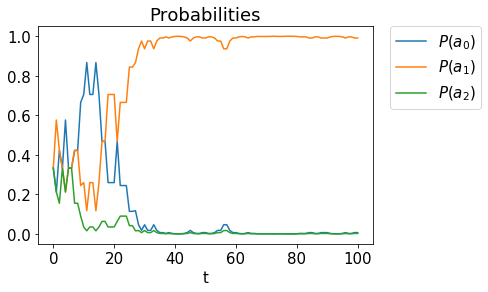

In [23]:
plt.plot(p)
plt.legend(('$P(a_0)$', '$P(a_1)$', '$P(a_2)$'),bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.title('Probabilities')
plt.xlabel('t')
plt.show()

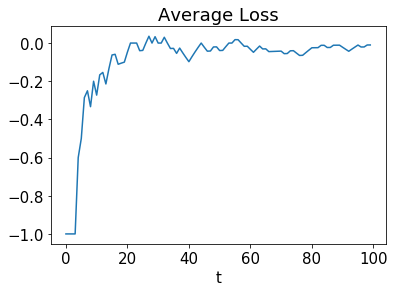

In [24]:
plt.plot(average_loss)
plt.title('Average Loss')
plt.xlabel('t')
plt.show()

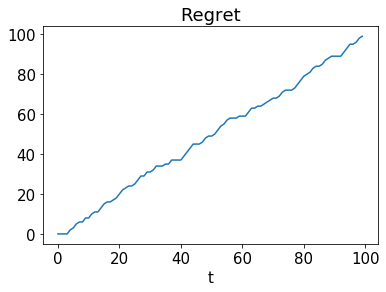

In [25]:
plt.plot(regret)
plt.title('Regret')
plt.xlabel('t')
plt.show()

In [26]:
N    = 10
average_losses = []
for n in range(N):
    _, _, average_loss_n, _ = simulate_EXP3(T, eta, L, q, 'fixed')
    average_losses.append(average_loss_n)

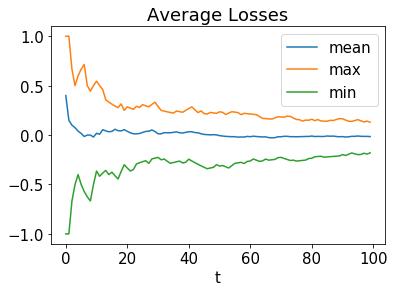

In [27]:
plt.plot(np.mean(average_losses,axis=0),label='mean')
plt.plot(np.max(average_losses,axis=0),label='max')
plt.plot(np.min(average_losses,axis=0),label='min')
plt.title('Average Losses')
plt.xlabel('t')
plt.legend()
plt.show()

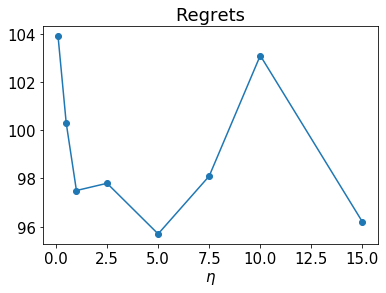

In [41]:
regrets = []
etas    = [ 0.1, 0.5, 1, 2.5, 5, 7.5, 10, 15]
for eta in etas:
    regret_i = []
    for n in range(N):
        _, _, _, regret = simulate_EXP3(T, eta, L, q, 'fixed')
        regret_i.append(regret[-1])
    regrets.append(np.mean(regret_i))
    
plt.plot(etas, regrets, 'o-')
plt.title('Regrets')
plt.xlabel('$\eta$')
plt.show()

__It seems that in practice, the best $\eta$ is around 5, while in theory it is optimal for $\eta = \sqrt{\frac{KT}{\log K}} $ (~8.07).__

## Question 7 : adaptative adversary

In [29]:
T   = 100
eta = 1
_, p, average_loss, _ = simulate_EXP3(T, eta, L, '', 'adaptative')

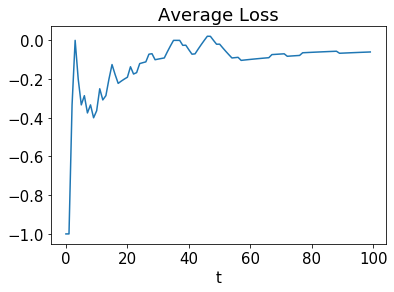

In [30]:
plt.plot(average_loss)
plt.title('Average Loss')
plt.xlabel('t')
plt.show()

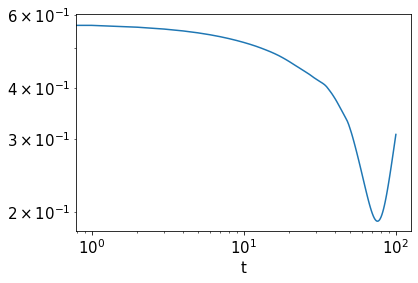

In [31]:
average_p = np.cumsum(p,axis=0)/T
plt.loglog(norm(average_p - [1/3, 1/3, 1/3], axis=1))
plt.xlabel('t')
plt.show()

# Optional extentions

In [32]:
def ucb(nb_tries, cum_rewards, c_param):

    #Try first all actions once
    if np.any(nb_tries==0):
        index = np.where(nb_tries == 0)[0]
        return np.random.choice(index,1)[0]
    else:
        t = nb_tries.sum()
        adapted_value = cum_rewards/nb_tries + c_param * np.sqrt(np.log(t)/nb_tries)
        return np.argmax(adapted_value)

In [33]:
def simulate_UCB_vs_EXP3(T, eta, L, q, c_param):
    
    # initialization
    loss = np.zeros(T)
    q0   = np.ones(len(L))/len(L)
    q    = np.tile(q0,(T+1,1))
    nb_tries    = np.zeros(len(L), int)
    cum_rewards = np.zeros(len(L), float)
    
    # loop over time
    for t in range(T):
        action_player = ucb(nb_tries, cum_rewards, c_param) 
        action_advers = rand_exp(q[t,:])
        loss[t]       = L[action_player, action_advers]
        q[t+1,:]      = EXP3_update(q[t,:], action_advers, L[action_advers,action_player], eta)
        
        nb_tries[action_player]    += 1
        cum_rewards[action_player] += loss[t]
    
    # compute quantities
    average_loss = np.cumsum(loss)/(np.arange(T)+1)
    regret       = np.cumsum(loss - (-1))

    return loss, p, average_loss, regret

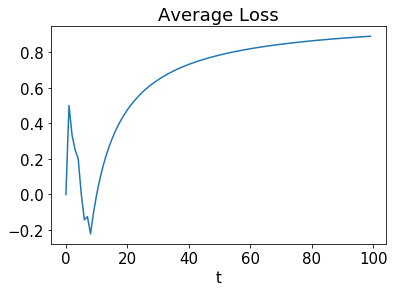

In [34]:
c_param = 1
T   = 100
eta = 1
loss, p, average_loss, regret = simulate_UCB_vs_EXP3(T, eta, L, q, c_param)

plt.plot(average_loss), plt.title('Average Loss'), plt.xlabel('t')
plt.show()

__For this game, it seems that UCB win over EXP3.__